<a href="https://colab.research.google.com/github/mansibora20/PySpark/blob/main/04_RDD_Advanced_Operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [7]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import random
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Initialize Spark Session

In [8]:
spark = SparkSession.builder.appName("RDDs_Advanced_Operations").getOrCreate()
sc = spark.sparkContext

Generate dataset with random values

In [9]:
# Generate random retail sales data
def generate_sales_data(n=1000):
    products = ["Laptop", "Smartphone", "Headphones", "Keyboard", "Mouse", "Monitor", "Tablet", "Smartwatch"]
    stores = ["New York", "Los Angeles", "Chicago", "Houston", "San Francisco"]
    start_date = datetime(2023, 1, 1)

    data = []
    for _ in range(n):
        customer_id = random.randint(1000, 5000)
        product = random.choice(products)
        category = "Electronics" if product in ["Laptop", "Smartphone", "Tablet", "Smartwatch", "Monitor"] else "Accessories"
        store = random.choice(stores)
        amount = round(random.uniform(50, 2000), 2)
        date = start_date + timedelta(days=random.randint(0, 365))
        data.append((customer_id, product, category, store, amount, date.strftime('%Y-%m-%d')))
    return data

Create RDD

In [10]:
sales_rdd = sc.parallelize(generate_sales_data(5000))

Print initial dataset

In [11]:
print("Sample Sales Data:")
for row in sales_rdd.take(5):
    print(row)

Sample Sales Data:
(2078, 'Mouse', 'Accessories', 'Houston', 904.21, '2023-08-22')
(2349, 'Smartphone', 'Electronics', 'Los Angeles', 1171.89, '2023-10-11')
(4495, 'Tablet', 'Electronics', 'Los Angeles', 640.71, '2023-03-02')
(2337, 'Smartphone', 'Electronics', 'Chicago', 1329.2, '2023-06-18')
(4398, 'Tablet', 'Electronics', 'Houston', 1618.76, '2023-04-06')


Total Sales Amount

In [12]:
total_sales = sales_rdd.map(lambda x: x[4]).sum()
print(f"Total Sales Revenue: ${total_sales:.2f}")



Total Sales Revenue: $5169531.43


Count of Transactions

In [13]:

num_transactions = sales_rdd.count()
print(f" Total Transactions: {num_transactions}")

 Total Transactions: 5000


Unique Products Sold

In [14]:
unique_products = sales_rdd.map(lambda x: x[1]).distinct().collect()
print(f"Unique Products Sold: {unique_products}")

Unique Products Sold: ['Headphones', 'Laptop', 'Monitor', 'Mouse', 'Smartphone', 'Tablet', 'Keyboard', 'Smartwatch']


Total Sales by Store

In [15]:
store_sales = sales_rdd.map(lambda x: (x[3], x[4])).reduceByKey(lambda x, y: x + y)
print("Sales by Store:", store_sales.collect())

Sales by Store: [('Houston', 1047731.2899999996), ('Los Angeles', 1013685.22), ('New York', 1063237.7300000004), ('Chicago', 1031219.4299999999), ('San Francisco', 1013657.7599999999)]


 Most Popular Products

In [16]:
popular_products = sales_rdd.map(lambda x: (x[1], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False)
print("Most Popular Products:", popular_products.take(5))

Most Popular Products: [('Monitor', 667), ('Tablet', 657), ('Laptop', 630), ('Mouse', 623), ('Keyboard', 616)]


Average Sale Amount

In [17]:
avg_sales = sales_rdd.map(lambda x: x[4]).mean()
print(f" Average Sale Amount: ${avg_sales:.2f}")

 Average Sale Amount: $1033.91


Sales Trend Over Time

In [26]:
from collections import defaultdict
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Aggregate sales by date
sales_by_date = sales_rdd.map(lambda x: (x[5], x[4])).reduceByKey(lambda x, y: x + y).collect()

# Convert to dictionary for plotting
date_sales_dict = defaultdict(float)
for date, amount in sales_by_date:
    date_sales_dict[date] = amount

# Sort by date
sorted_sales = sorted(date_sales_dict.items())

# Extract dates and sales amounts
dates, sales = zip(*sorted_sales)

# Create interactive Plotly plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dates,
    y=sales,
    mode="lines+markers",
    marker=dict(size=6, color="blue"),
    line=dict(width=2),
    name="Sales Revenue",
    hovertemplate="<b>Date:</b> %{x}<br><b>Sales:</b> $%{y:.2f}<extra></extra>"
))

# Improve layout
fig.update_layout(
    title="Sales Trend Over Time",
    xaxis=dict(title="Date", tickangle=-45, tickformat="%Y-%m-%d"),
    yaxis=dict(title="Total Sales ($)"),
    hovermode="x unified",
    plot_bgcolor="white",
    xaxis_showgrid=True,
    yaxis_showgrid=True
)

# Show interactive plot
fig.show()


Sales Trend Over Time (GitHub-Compatible Version)

<ipython-input-27-19bee0b0b269>:39: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



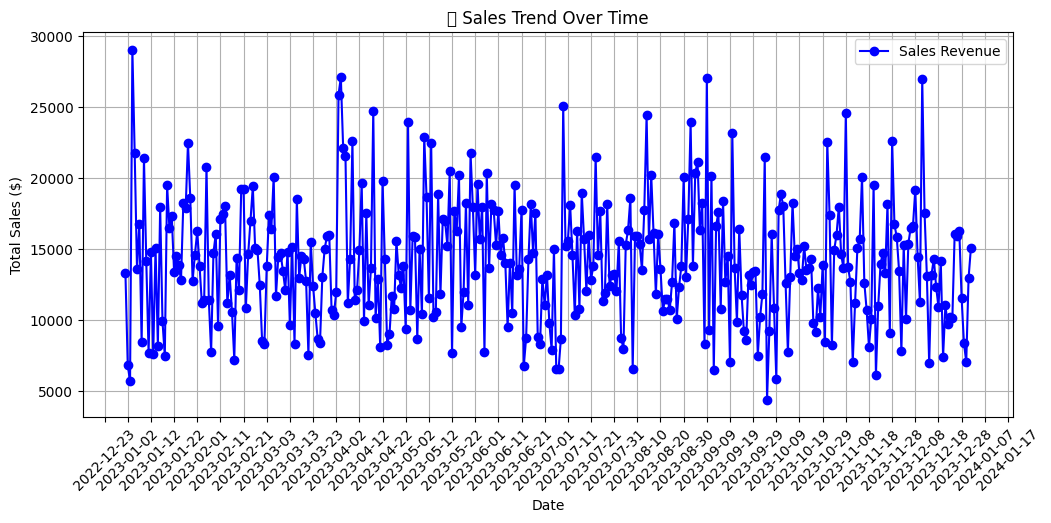

In [27]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Aggregate sales by date
sales_by_date = sales_rdd.map(lambda x: (x[5], x[4])).reduceByKey(lambda x, y: x + y).collect()

# Convert to dictionary for plotting
date_sales_dict = defaultdict(float)
for date, amount in sales_by_date:
    date_sales_dict[date] = amount

# Sort by date
sorted_sales = sorted(date_sales_dict.items())

# Extract dates and sales amounts
dates, sales = zip(*sorted_sales)

# Convert string dates to datetime for better plotting
import datetime
dates = [datetime.datetime.strptime(d, "%Y-%m-%d") for d in dates]

# Create Matplotlib plot
plt.figure(figsize=(12, 5))
plt.plot(dates, sales, marker="o", linestyle="-", color="blue", label="Sales Revenue")

# Format x-axis for better date visibility
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Adjust interval as needed

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Total Sales ($)")
plt.title("📈 Sales Trend Over Time")
plt.legend()
plt.grid()

# Save as PNG for GitHub visibility
plt.savefig("sales_trend.png", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


Top Spending Customers



In [28]:
top_customers = sales_rdd.map(lambda x: (x[0], x[4])).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False)
print("Top Spending Customers:", top_customers.take(5))


Top Spending Customers: [(4266, 8760.36), (3934, 7338.389999999999), (4854, 6960.82), (4511, 6821.87), (3621, 6794.429999999999)]


Category-wise Sales Breakdown

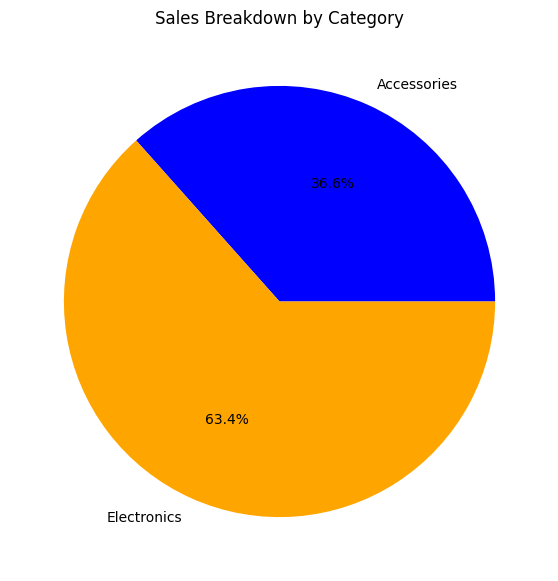

In [29]:
category_sales = sales_rdd.map(lambda x: (x[2], x[4])).reduceByKey(lambda x, y: x + y).collect()
categories, amounts = zip(*category_sales)

# Pie Chart for Category Sales
plt.figure(figsize=(7, 7))
plt.pie(amounts, labels=categories, autopct="%1.1f%%", colors=["blue", "orange"])
plt.title("Sales Breakdown by Category")
plt.show()


Filtering Transactions Above a Threshold

In [30]:
high_value_sales = sales_rdd.filter(lambda x: x[4] > 1000)
print("High-Value Transactions (Above $1000):", high_value_sales.take(5))


High-Value Transactions (Above $1000): [(2349, 'Smartphone', 'Electronics', 'Los Angeles', 1171.89, '2023-10-11'), (2337, 'Smartphone', 'Electronics', 'Chicago', 1329.2, '2023-06-18'), (4398, 'Tablet', 'Electronics', 'Houston', 1618.76, '2023-04-06'), (1471, 'Smartphone', 'Electronics', 'Houston', 1582.52, '2023-02-24'), (3745, 'Keyboard', 'Accessories', 'Los Angeles', 1668.38, '2023-02-11')]


 Join Operations (Customer-Based Analysis)

In [31]:
# Create RDD with customer demographic data
customers_rdd = sc.parallelize([(1001, "Alice", "NY"), (1002, "Bob", "LA"), (1003, "Charlie", "SF")])

# Convert sales RDD to (CustomerID, (Product, Amount))
sales_customers_rdd = sales_rdd.map(lambda x: (x[0], (x[1], x[4])))

# Join with customer data
joined_rdd = sales_customers_rdd.join(customers_rdd)
print(" Customer Purchases with Demographics:", joined_rdd.take(5))


 Customer Purchases with Demographics: [(1003, (('Smartphone', 1368.48), 'Charlie')), (1003, (('Smartphone', 1453.62), 'Charlie'))]


Finding Maximum Sale per Store

In [32]:
max_sales_per_store = sales_rdd.map(lambda x: (x[3], x[4])).reduceByKey(lambda x, y: max(x, y))
print("Highest Sale per Store:", max_sales_per_store.collect())


Highest Sale per Store: [('Houston', 1998.9), ('Los Angeles', 1998.29), ('New York', 1999.76), ('Chicago', 1997.07), ('San Francisco', 1993.18)]


 Performance Optimization
 Cache RDD for faster computations

In [33]:

sales_rdd.cache()
print("RDD Cached for Performance Optimization")

RDD Cached for Performance Optimization






 Final Business Insights
* Total Revenue Generated
* Most Popular Products & Best Performing Stores
* Sales Trends Over Time (Visualized)
* Top Spending Customers
* Category-wise Revenue Breakdown (Pie Chart)
* Finding High-Value Transactions
* Customer Demographics & Purchases
* Optimized Performance using Caching